In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


# In the event of ssl failure
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')



[nltk_data] Downloading package stopwords to /Users/inesh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/inesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
csv_file = '/Users/lijaa/downloads/Singhealth/singhealth_jobs.csv'

## 1. FUNCTION: Bar Chart by Years of Experience & Job Category

In [15]:
def analyze_experience_distribution(csv_file, output_prefix='healthcare_jobs', display_plots=True):
    """
    Analyzes the distribution of required years of experience in job postings.
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing job data
    output_prefix : str
        Prefix for the output files. Will create three files with this prefix
    display_plots : bool
        Whether to display the plots in addition to saving them (default: True)
    """
    # Required imports
    import pandas as pd
    import re
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Load data
    df = pd.read_csv(csv_file)
    
    # Clean requirements column
    df['clean_requirements'] = df['Job Requirements'].fillna('').str.replace('\n', ' ').replace('•', '').replace(r'\s+', ' ', regex=True).str.strip()
    
    # Extract years of experience using regex patterns
    def extract_years(text):
        if pd.isna(text) or text == '':
            return None
        
        patterns = [
            r'(\d+)\s*(?:-|to)\s*(\d+)\s*years?',  # "X-Y years" or "X to Y years"
            r'(\d+)\s*years?',                      # "X years"
            r'minimum\s*of\s*(\d+)\s*years?',       # "minimum of X years"
            r'at\s*least\s*(\d+)\s*years?'          # "at least X years"
        ]
        
        for pattern in patterns:
            match = re.search(pattern, text, re.IGNORECASE)
            if match:
                # If it's a range, return the lower bound
                if len(match.groups()) > 1 and match.group(2):
                    return int(match.group(1))
                # Single value
                return int(match.group(1))
        return None
    
    # Apply extraction to all rows
    df['years_experience'] = df['clean_requirements'].apply(extract_years)
    
    # Categorize job types for more meaningful analysis
    def categorize_job_detailed(title):
        title = str(title).lower()
        
        # Technical/Specialized Healthcare
        if any(k in title for k in ['technician', 'technologist', 'sterile', 'instrument']):
            return 'Technical Healthcare'
            
        # Patient-Facing Services
        if any(k in title for k in ['patient service', 'care support', 'patient experience', 'call centre']):
            return 'Patient Services'
            
        # Therapy Specializations
        if 'speech' in title and ('therapy' in title or 'therapist' in title):
            return 'Speech Therapy'
        if any(k in title for k in ['physiotherapist', 'physical therapy']):
            return 'Physiotherapy'
        if any(k in title for k in ['occupational therapist', 'occupational therapy']):
            return 'Occupational Therapy'
        if 'podiatrist' in title:
            return 'Podiatry'
            
        # Administrative Subcategories
        if any(k in title for k in ['finance', 'accountant', 'business office']):
            return 'Finance & Business'
        if any(k in title for k in ['data', 'analyst', 'statistics']):
            return 'Data & Analytics'
        if any(k in title for k in ['facilities', 'engineer', 'biomedical']):
            return 'Facilities & Engineering'
        if any(k in title for k in ['project', 'planning']):
            return 'Project & Planning'
        
        # Laboratory & Research
        if any(k in title for k in ['laboratory', 'lab scientist']):
            return 'Laboratory Science'
        if any(k in title for k in ['research', 'clinical research']):
            return 'Research'
        
        # Medical Specialties
        if 'resident physician' in title:
            return 'Resident Physicians'
        if any(k in title for k in ['consultant', 'specialist']):
            return 'Consultants & Specialists'
        
        # Social Services
        if any(k in title for k in ['social worker', 'community health']):
            return 'Social Services'
            
        # Original broader categories as fallbacks
        if any(k in title for k in ['physician', 'doctor', 'surgeon', 'medical']):
            return 'Medical'
        elif any(k in title for k in ['nurse', 'nursing']):
            return 'Nursing'
        elif any(k in title for k in ['therapist', 'pharmacist', 'dietitian']) and 'assistant' not in title:
            return 'Allied Health'
        elif any(k in title for k in ['executive', 'manager', 'administrator', 'coordinator', 'officer']):
            return 'Administrative'
        else:
            return 'Other'
    
    # Apply the detailed categorization
    df['job_category'] = df['Job Title'].apply(categorize_job_detailed)
    
    # Get basic stats
    jobs_with_exp = df['years_experience'].notna().sum()
    total_jobs = len(df)
    
    print(f"Jobs with specific years of experience: {jobs_with_exp}/{total_jobs} ({jobs_with_exp/total_jobs*100:.2f}%)")
    
    # Count experience years distribution
    exp_counts = df['years_experience'].value_counts().sort_index()
    
    print("\nExperience Requirements Distribution:")
    for years, count in exp_counts.items():
        if pd.notna(years):
            print(f"{years} years: {count} jobs ({count/jobs_with_exp*100:.2f}%)")
    
    # Calculate average experience required by job category
    category_exp = df.groupby('job_category')['years_experience'].agg(['mean', 'count', lambda x: x.notna().sum()])
    category_exp.columns = ['avg_years', 'total_jobs', 'jobs_with_exp']
    category_exp['pct_with_exp'] = (category_exp['jobs_with_exp'] / category_exp['total_jobs'] * 100).round(1)
    category_exp['avg_years'] = category_exp['avg_years'].round(1)
    
    print("\nAverage Experience Requirements by Job Category:")
    print(category_exp[['avg_years', 'jobs_with_exp', 'total_jobs', 'pct_with_exp']])
    
    # Format the output as requested
    print("\n**Average Job Experience with Category**")
    for category, row in category_exp.iterrows():
        print(f"**{category}**")
        print(f"Average Years: {row['avg_years']}")
        print(f"Total Jobs: {row['jobs_with_exp']} out of {row['total_jobs']} ({row['pct_with_exp']}%)")
        print()
    
    # Experience level classification
    df['experience_level'] = pd.cut(
        df['years_experience'], 
        bins=[-1, 2, 5, float('inf')],
        labels=['Entry Level (0-2 yrs)', 'Mid Level (3-5 yrs)', 'Senior Level (6+ yrs)']
    )
    
    # Create a list to store figure objects
    figures = []
    
    # Plot 1: Job category counts with value labels
    fig1 = plt.figure(figsize=(12, 8))
    figures.append(fig1)
    category_counts = df['job_category'].value_counts().sort_values(ascending=False)
    ax1 = category_counts.plot(kind='barh')
    plt.title('Distribution of Detailed Job Categories', fontsize=14)
    plt.xlabel('Number of Job Postings')
    plt.ylabel('Job Category')
    
    # Add value labels to job category bars
    for i, v in enumerate(category_counts):
        ax1.text(v + 1, i, str(v), va='center')
    
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_job_categories.png", dpi=300, bbox_inches='tight')
    if not display_plots:
        plt.close(fig1)
    
    # Plot 2: Overall experience distribution with value labels
    fig2 = plt.figure(figsize=(12, 6))
    figures.append(fig2)
    ax2 = sns.countplot(x='years_experience', data=df.dropna(subset=['years_experience']), palette='viridis')
    plt.title('Distribution of Required Years of Experience', fontsize=14)
    plt.xlabel('Years of Experience')
    plt.ylabel('Number of Jobs')
    
    # Add value labels to experience distribution bars
    for p in ax2.patches:
        ax2.annotate(
            f'{int(p.get_height())}', 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', va='bottom', 
            fontsize=9, rotation=0
        )
    
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_experience_distribution.png", dpi=300, bbox_inches='tight')
    if not display_plots:
        plt.close(fig2)
    
    # Plot 3: Experience by job category (top 10 categories)
    fig3 = plt.figure(figsize=(12, 7))
    figures.append(fig3)
    top_categories = df['job_category'].value_counts().nlargest(10).index
    filtered_df = df[df['job_category'].isin(top_categories)]
    
    category_level_counts = pd.crosstab(filtered_df['job_category'], filtered_df['experience_level'])
    category_level_counts['Total'] = category_level_counts.sum(axis=1)
    category_level_counts = category_level_counts.sort_values(by='Total', ascending=False).drop(columns='Total')
    ax3 = category_level_counts.plot(kind='bar', stacked=True, colormap='viridis')
    ax3.set_xticks(range(len(category_level_counts)))  
    ax3.set_xticklabels(category_level_counts.index, rotation=45, ha='right')
    plt.title('Experience Levels by Top 10 Job Categories', fontsize=14)
    plt.xlabel('Job Category')
    plt.ylabel('Number of Jobs')
    plt.xticks(rotation=45)
    plt.legend(title='Experience Level')
    
    if 'Entry Level (0-2 yrs)' in category_level_counts.columns:
        entry_counts = category_level_counts['Entry Level (0-2 yrs)'].values
        total_counts = category_level_counts.sum(axis=1).values
        entry_percents = (entry_counts / total_counts) * 100

    for i, (height, pct) in enumerate(zip(entry_counts, entry_percents)):
        if pct > 50 and height > 0:
            ax3.text(
                i,
                height / 2,  # middle of the entry-level bar
                f'{pct:.1f}%',
                ha='center',
                va='center',
                color='white',
                fontsize=6,
                fontweight='bold'
            )


    
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_experience_levels.png", dpi=300, bbox_inches='tight')
    if not display_plots:
        plt.close(fig3)
    
    # Display all plots if requested
    if display_plots:
        plt.show()
    
    return df, exp_counts, category_exp, figures

Jobs with specific years of experience: 278/540 (51.48%)

Experience Requirements Distribution:
1.0 years: 41 jobs (14.75%)
2.0 years: 94 jobs (33.81%)
3.0 years: 29 jobs (10.43%)
4.0 years: 26 jobs (9.35%)
5.0 years: 16 jobs (5.76%)
6.0 years: 29 jobs (10.43%)
7.0 years: 2 jobs (0.72%)
8.0 years: 19 jobs (6.83%)
10.0 years: 14 jobs (5.04%)
12.0 years: 5 jobs (1.80%)
15.0 years: 2 jobs (0.72%)
17.0 years: 1 jobs (0.36%)

Average Experience Requirements by Job Category:
                           avg_years  jobs_with_exp  total_jobs  pct_with_exp
job_category                                                                 
Administrative                   3.8             77          77         100.0
Allied Health                    3.8              5           5         100.0
Consultants & Specialists        3.0              4           4         100.0
Data & Analytics                 3.6              8           8         100.0
Facilities & Engineering         4.4             16       

/var/folders/pl/xc9bh78x2450rhb6n_q0b7tm0000gp/T/ipykernel_59418/1929071042.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(x='years_experience', data=df.dropna(subset=['years_experience']), palette='viridis')


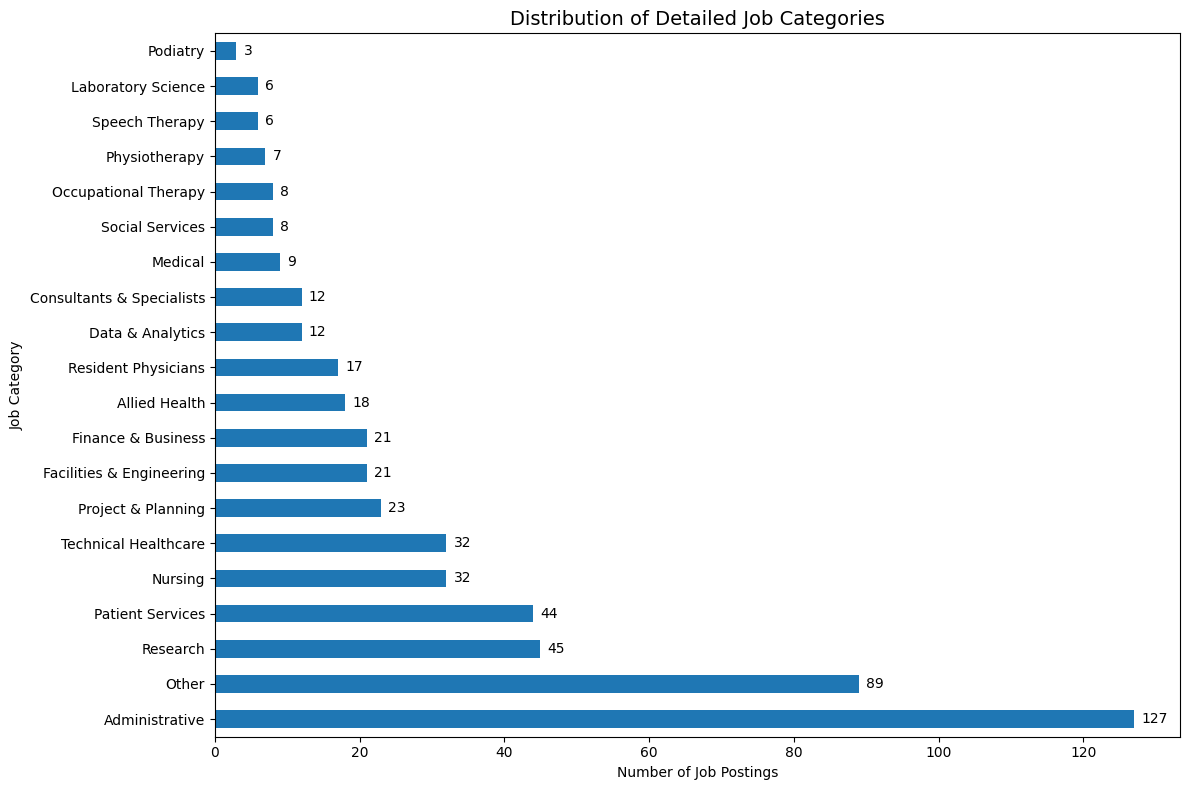

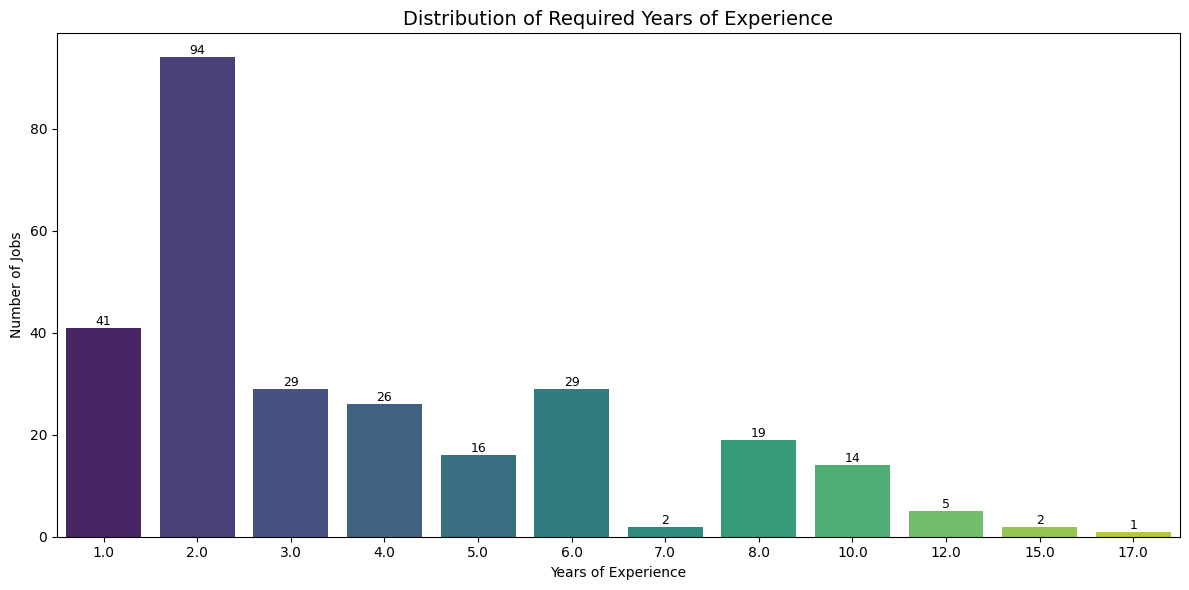

<Figure size 1200x700 with 0 Axes>

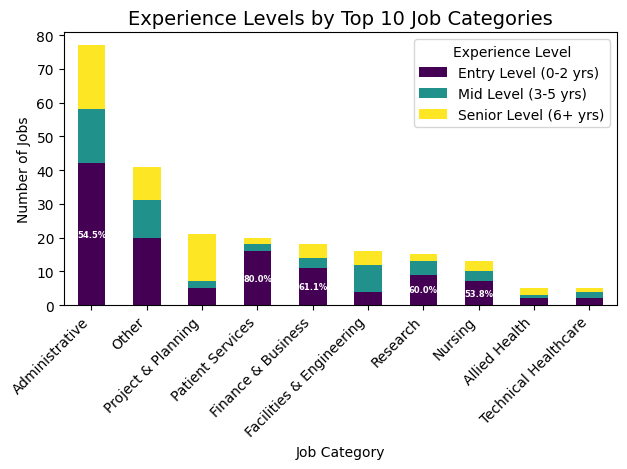

(                                             Job Title  \
 0                                       Rheumatologist   
 1          Resident Physician, Rehabilitation Medicine   
 2              Resident Physician, Palliative Medicine   
 3        Senior/Principal Medical Laboratory Scientist   
 4                               Geriatric Psychiatrist   
 ..                                                 ...   
 535  Senior / Patient Service Associate, Outpatient...   
 536  Senior/Executive, Compensation & Performance M...   
 537                      Clinical Research Coordinator   
 538                                  Senior/ Executive   
 539                      Executive, Talent Development   
 
                                               Hospital Job Type  \
 0                                              Unknown      NaN   
 1                                              Unknown      NaN   
 2                                              Unknown      NaN   
 3                

In [16]:
# Example usage
analyze_experience_distribution('singhealth_jobs_20250329_225135.csv', 'healthcare_analysis')

## 2. FUNCTION: Heatmap by Skillsets

In [50]:
def create_skills_heatmap(csv_file, output_file='skills_heatmap.png'):
    """
    Create a heatmap visualization showing the percentage of jobs requiring
    various skills across different job categories.
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing job data
    output_file : str
        Path where the heatmap image will be saved
    """
    # Load the data
    df = pd.read_csv(csv_file)
    
    # Basic cleaning of requirements column
    df['clean_requirements'] = df['Job Requirements'].fillna('').str.replace('\n', ' ')
    df['clean_requirements'] = df['clean_requirements'].str.replace('•', '')
    df['clean_requirements'] = df['clean_requirements'].str.replace(r'\s+', ' ', regex=True)
    df['clean_requirements'] = df['clean_requirements'].str.strip()
    
    # Categorize jobs
    def categorize_job(title):
        if pd.isna(title):
            return 'Other'
            
        title = str(title).lower()
        if any(k in title for k in ['physician', 'doctor', 'specialist', 'consultant', 'surgeon', 'medical']):
            return 'Medical'
        elif any(k in title for k in ['nurse', 'nursing']):
            return 'Nursing'
        elif any(k in title for k in ['therapist', 'physiotherapist', 'pharmacist', 'dietitian', 'radiographer']):
            return 'Allied Health'
        elif any(k in title for k in ['research', 'scientist', 'laboratory']):
            return 'Research'
        elif any(k in title for k in ['executive', 'manager', 'administrator', 'coordinator', 'officer']):
            return 'Administrative'
        else:
            return 'Other'
    
    df['job_category'] = df['Job Title'].apply(categorize_job)
    
    # Define skills to analyze
    technical_skills = [
        "microsoft", "excel", "word", "data", "analytics", 
        "statistics", "technical", "computer", "software", "programming"
    ]
    
    soft_skills = [
        "communication", "interpersonal", "teamwork", "leadership", 
        "detail", "initiative", "problem solving", "adaptable", 
        "flexible", "organized"
    ]
    
    clinical_skills = [
        "patient care", "clinical", "diagnostic", "treatment", "medical knowledge",
        "healthcare", "therapeutic", "assessment", "nursing", "surgical"
    ]
    
    # We'll analyze these combined skills
    all_skills = technical_skills + soft_skills + clinical_skills
    
    # Create flags for each skill
    for skill in all_skills:
        df[f'has_{skill}'] = df['clean_requirements'].str.contains(skill, case=False)
    
    # Create a DataFrame to hold percentages for the heatmap
    skill_percentages = pd.DataFrame(index=sorted(df['job_category'].unique()), 
                                    columns=all_skills)
    
    # Calculate the percentage of jobs requiring each skill within each category
    for category in skill_percentages.index:
        category_df = df[df['job_category'] == category]
        total_in_category = len(category_df)
        
        if total_in_category > 0:  # Avoid division by zero
            for skill in all_skills:
                skill_count = category_df[f'has_{skill}'].sum()
                skill_percentages.loc[category, skill] = (skill_count / total_in_category) * 100
        else:
            for skill in all_skills:
                skill_percentages.loc[category, skill] = 0
    
    # Fill NaN values with 0
    skill_percentages = skill_percentages.fillna(0)
    
    # Create the heatmap visualization
    plt.figure(figsize=(16, 10))
    
    # Create heatmap
    sns.heatmap(skill_percentages, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=.5)
    
    # Add titles and labels
    plt.title('Skills Requirements by Job Category (%)', fontsize=16, pad=20)
    plt.xlabel('Skills', fontsize=14, labelpad=10)
    plt.ylabel('Job Category', fontsize=14, labelpad=10)
    
    # Add visual separators between skill types
    plt.axvline(x=len(technical_skills), color='white', linewidth=2)
    plt.axvline(x=len(technical_skills) + len(soft_skills), color='white', linewidth=2)
    
    # Add annotations for skill categories
    skill_category_positions = [
        len(technical_skills) / 2,
        len(technical_skills) + len(soft_skills) / 2,
        len(technical_skills) + len(soft_skills) + len(clinical_skills) / 2
    ]
    
    for i, label in enumerate(['Technical Skills', 'Soft Skills', 'Clinical Skills']):
        plt.text(skill_category_positions[i], -0.5, label, 
                 ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    
    print(f"Heatmap saved to {output_file}")
    
    # Return the DataFrame with percentages
    return skill_percentages



/var/folders/32/yk92ldn108zgrfqm8r2sdlkm0000gn/T/ipykernel_6233/3766929572.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  skill_percentages = skill_percentages.fillna(0)


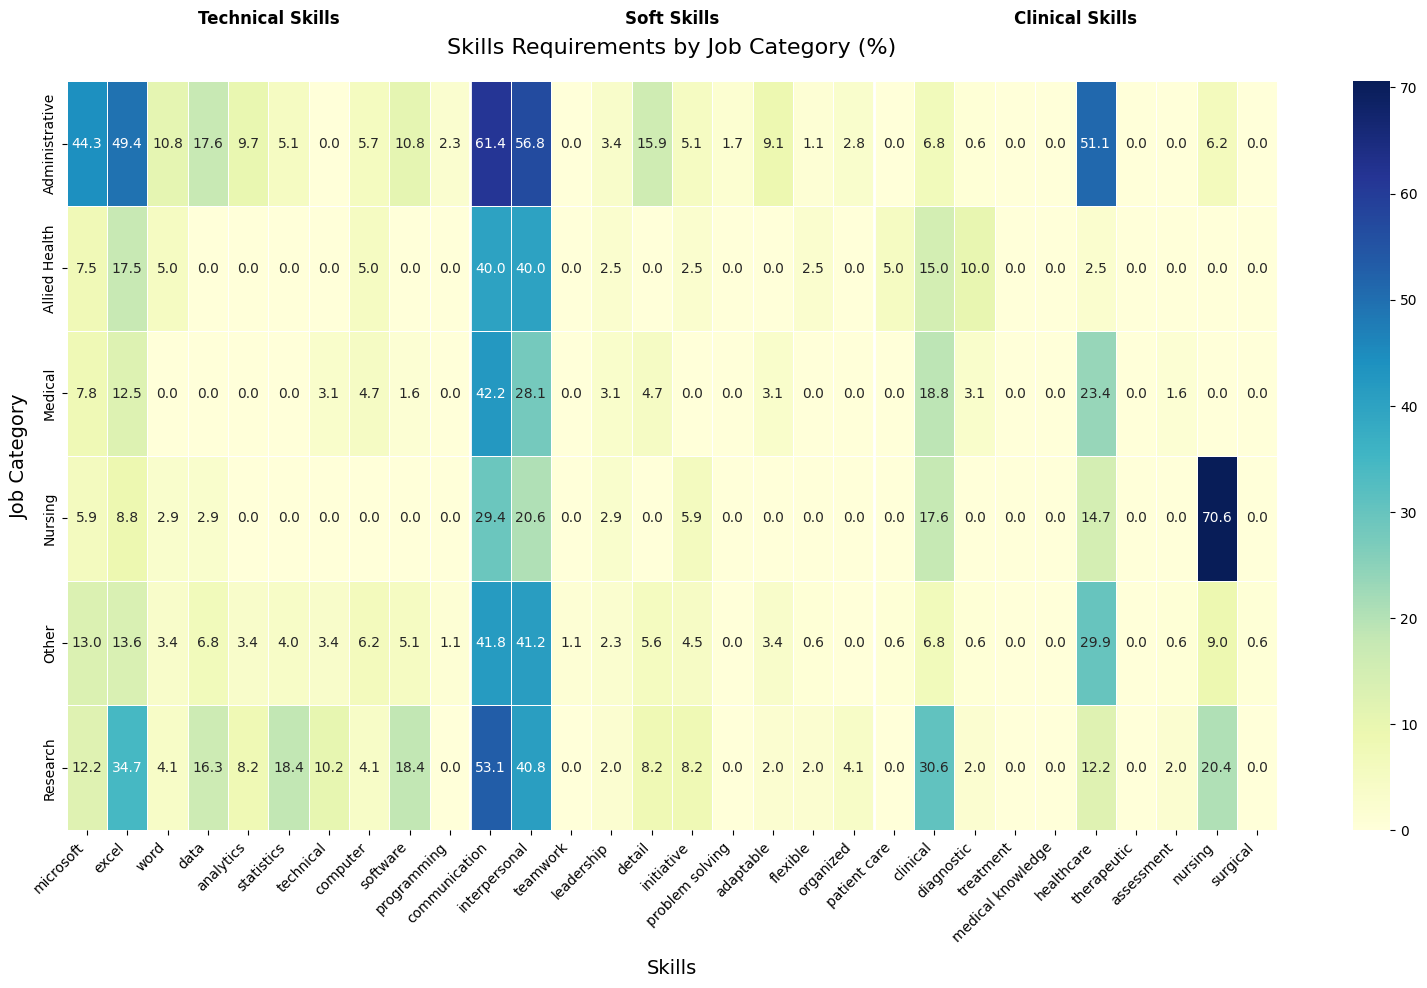

Heatmap saved to skills_heatmap.png

Skill requirement percentages by job category:
                microsoft      excel       word       data  analytics  \
Administrative  44.318182  49.431818  10.795455  17.613636   9.659091   
Allied Health    7.500000  17.500000   5.000000   0.000000   0.000000   
Medical          7.812500  12.500000   0.000000   0.000000   0.000000   
Nursing          5.882353   8.823529   2.941176   2.941176   0.000000   
Other           12.994350  13.559322   3.389831   6.779661   3.389831   
Research        12.244898  34.693878   4.081633  16.326531   8.163265   

                statistics  technical  computer   software  programming  ...  \
Administrative    5.113636   0.000000  5.681818  10.795455     2.272727  ...   
Allied Health     0.000000   0.000000  5.000000   0.000000     0.000000  ...   
Medical           0.000000   3.125000  4.687500   1.562500     0.000000  ...   
Nursing           0.000000   0.000000  0.000000   0.000000     0.000000  ...   
Othe

In [51]:
# Example usage
skill_data = create_skills_heatmap(csv_file)
print("\nSkill requirement percentages by job category:")
print(skill_data)

## 3. FUNCTION: Word Cloud by Job Category

In [52]:
def create_requirements_word_clouds(csv_file, output_folder='.'):
    """
    Creates word clouds visualizing the most common terms in job requirements
    for each job category.
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing job data
    output_folder : str
        Directory where word cloud images will be saved
    """
    # Download NLTK resources if needed
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    
    # Load data
    df = pd.read_csv(csv_file)
    
    # Clean requirements text
    df['clean_requirements'] = df['Job Requirements'].fillna('')
    df['clean_requirements'] = df['clean_requirements'].str.replace('\n', ' ')
    df['clean_requirements'] = df['clean_requirements'].str.replace('•', '')
    df['clean_requirements'] = df['clean_requirements'].str.replace(r'\s+', ' ', regex=True)
    df['clean_requirements'] = df['clean_requirements'].str.strip()
    
    # Categorize jobs
    def categorize_job(title):
        if pd.isna(title):
            return 'Other'
            
        title = str(title).lower()
        if any(k in title for k in ['physician', 'doctor', 'specialist', 'consultant', 'surgeon', 'medical']):
            return 'Medical'
        elif any(k in title for k in ['nurse', 'nursing']):
            return 'Nursing'
        elif any(k in title for k in ['therapist', 'physiotherapist', 'pharmacist', 'dietitian', 'radiographer']):
            return 'Allied Health'
        elif any(k in title for k in ['research', 'scientist', 'laboratory']):
            return 'Research'
        elif any(k in title for k in ['executive', 'manager', 'administrator', 'coordinator', 'officer']):
            return 'Administrative'
        else:
            return 'Other'
    
    df['job_category'] = df['Job Title'].apply(categorize_job)
    
    # Get standard stopwords
    stop_words = set(stopwords.words('english'))
    
    # Add custom stopwords specific to job requirements
    custom_stopwords = {
        'must', 'should', 'will', 'able', 'etc', 'including', 'required', 'any',
        'year', 'years', 'experience', 'job', 'work', 'working', 'role',
        'qualifications', 'qualification', 'duties', 'requirements', 'required',
        'applicants', 'candidate', 'candidates', 'apply', 'application',
        'singhealth', 'sgh', 'singapore', 'hospital', 'group', 'rights',
        'reserved', 'staff', '2022', 'one', 'two', 'three', 'please'
    }
    stop_words.update(custom_stopwords)
    
    # Create output folder if it doesn't exist
    import os
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Dictionary to store word frequencies by category
    category_word_freqs = {}
    
    # Generate word clouds for each category
    for category in sorted(df['job_category'].unique()):
        # Get all requirements text for this category
        category_reqs = df[df['job_category'] == category]['clean_requirements'].fillna('').str.cat(sep=' ')
        
        # Continue only if we have enough text
        if len(category_reqs) < 100:
            print(f"Not enough text for category: {category}")
            continue
            
        # Clean text: lowercase and remove punctuation
        category_reqs = category_reqs.lower()
        category_reqs = re.sub(r'[^\w\s]', ' ', category_reqs)
        
        # Remove stopwords
        words = category_reqs.split()
        filtered_text = ' '.join([word for word in words if word not in stop_words and len(word) > 2])
        
        # Create and save word cloud
        wc = WordCloud(
            width=800, 
            height=400, 
            background_color='white', 
            max_words=100,
            colormap='viridis',
            contour_width=1,
            contour_color='steelblue'
        ).generate(filtered_text)
        
        # Save word cloud image
        output_path = f"{output_folder}/wordcloud_{category.lower().replace(' ', '_')}.png"
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Common Requirements for {category} Jobs')
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Word cloud for {category} saved to {output_path}")
        
        # Store word frequencies for this category
        words_freq = wc.words_
        category_word_freqs[category] = dict(sorted(words_freq.items(), key=lambda x: x[1], reverse=True)[:20])
    
    # Print top words by category
    print("\nTop 10 words by job category:")
    for category, word_freq in category_word_freqs.items():
        top_words = list(word_freq.keys())[:10]
        print(f"{category}: {', '.join(top_words)}")
    
    # Create a comparative word cloud showing differences between categories
    if len(category_word_freqs) > 1:
        plt.figure(figsize=(15, 10))
        
        # Set up subplot grid based on number of categories
        n_categories = len(category_word_freqs)
        n_cols = min(3, n_categories)
        n_rows = (n_categories + n_cols - 1) // n_cols
        
        for i, (category, word_freq) in enumerate(category_word_freqs.items()):
            plt.subplot(n_rows, n_cols, i+1)
            
            # Create word cloud from dictionary
            wc = WordCloud(
                width=400, 
                height=200, 
                background_color='white',
                colormap='viridis',
                contour_width=1,
                contour_color='steelblue'
            ).generate_from_frequencies(word_freq)
            
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'{category}')
        
        plt.suptitle('Top Requirements by Job Category', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f"{output_folder}/comparative_wordclouds.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Comparative word clouds saved to {output_folder}/comparative_wordclouds.png")
    
    return category_word_freqs

# Example usage
if __name__ == "__main__":
    # Create word clouds and get word frequencies by category
    word_frequencies = create_requirements_word_clouds(
        csv_file='singhealth_jobs_20250329_225135.csv',
        output_folder='wordcloud_outputs'
    )
    
    # Print example of word frequencies for the first category
    if word_frequencies:
        first_category = list(word_frequencies.keys())[0]
        print(f"\nDetailed word frequencies for {first_category}:")
        for word, freq in list(word_frequencies[first_category].items())[:10]:
            print(f"  {word}: {freq:.4f}")

Word cloud for Administrative saved to wordcloud_outputs/wordcloud_administrative.png
Word cloud for Allied Health saved to wordcloud_outputs/wordcloud_allied_health.png
Word cloud for Medical saved to wordcloud_outputs/wordcloud_medical.png
Word cloud for Nursing saved to wordcloud_outputs/wordcloud_nursing.png
Word cloud for Other saved to wordcloud_outputs/wordcloud_other.png
Word cloud for Research saved to wordcloud_outputs/wordcloud_research.png

Top 10 words by job category:
Administrative: team player, microsoft office, good, management, communication skill, strong, bachelor degree, skill, knowledge, office applications
Allied Health: degree, allied health, relevant, equivalent, physiotherapy, communication skills, skills, ahpc, interpersonal communication, professional
Medical: basic medical, medical council, medical degree, relevant, communication skill, specialist, management, degree, clinical, skill
Nursing: nursing board, registered nursing, diploma nursing, recognised, le